## Configuração

In [1]:
import datetime
import json
import os
import pathlib

import cv2
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from tensorflow import keras
from tensorflow.keras import Input, Model, layers, models
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tqdm import tqdm

2024-12-17 23:21:29.304551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734488490.354744   73384 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734488490.661354   73384 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 23:21:33.098875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Path setup - Adjust the root directory accordingly
cwd = os.getcwd()
project_path = pathlib.Path(os.path.join(cwd, "..", "..")).resolve()
splits = ['train', 'valid', 'test']

date_str = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

In [3]:
class Config:
    max_trials = 2
    experiments_path = os.path.join(cwd, "..", "..", "experiments", "autoencoder", date_str)
    dataset_path = os.path.join(project_path, "data", "ships_v10i", "cropped")
    patience = 5
    epochs = 3
    batch_size = 8
    encoding_dim = 128
    imgsz = 128
    use_kmeans = True

In [4]:
os.makedirs(Config.experiments_path, exist_ok=True)

## Modelos

In [5]:
def build_autoencoder(input_shape, encoding_dim):
    # --- Build the full autoencoder in one continuous pass --- #
    inputs = tf.keras.Input(shape=input_shape, name="encoder_input")

    # Encoder layers
    x = layers.Conv2D(32, (3, 3), activation="relu",
                      padding="same", name="enc_conv1")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same", name="enc_pool1")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu",
                      padding="same", name="enc_conv2")(x)
    x = layers.MaxPooling2D((2, 2), padding="same", name="enc_pool2")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu",
                      padding="same", name="enc_conv3")(x)
    x = layers.MaxPooling2D((2, 2), padding="same", name="enc_pool3")(x)

    shape_before_flattening = x.shape[1:]  # (H, W, C)
    flattened_dim = np.prod(shape_before_flattening)
    x = layers.Flatten(name="enc_flatten")(x)
    encoded = layers.Dense(encoding_dim, activation="relu", name="latent")(x)

    # Decoder layers
    x_dec = layers.Dense(flattened_dim, activation="relu",
                         name="dec_dense")(encoded)
    x_dec = layers.Reshape((shape_before_flattening[0],
                            shape_before_flattening[1],
                            shape_before_flattening[2]),
                           name="dec_reshape")(x_dec)
    x_dec = layers.Conv2DTranspose(
        128, (3, 3), strides=2, padding="same", activation="relu", name="dec_convT1")(x_dec)
    x_dec = layers.Conv2DTranspose(
        64, (3, 3), strides=2, padding="same", activation="relu", name="dec_convT2")(x_dec)
    x_dec = layers.Conv2DTranspose(
        32, (3, 3), strides=2, padding="same", activation="relu", name="dec_convT3")(x_dec)
    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid",
                            padding="same", name="decoder_output")(x_dec)

    # Full autoencoder model
    autoencoder = Model(inputs, decoded, name="autoencoder_model")

    # --- Extract encoder model ---
    # The encoder goes from the original input to the latent representation.
    encoder = Model(inputs, encoded, name="encoder_model")

    # --- Extract decoder model ---
    # The decoder takes latent vectors and reconstructs images.
    # We must replicate the decoder path using the same shapes.
    latent_inputs = tf.keras.Input(shape=(encoding_dim,), name="decoder_input")
    # Rebuild decoder layers separately, in the same order as above:
    x_d = autoencoder.get_layer("dec_dense")(latent_inputs)
    x_d = autoencoder.get_layer("dec_reshape")(x_d)
    x_d = autoencoder.get_layer("dec_convT1")(x_d)
    x_d = autoencoder.get_layer("dec_convT2")(x_d)
    x_d = autoencoder.get_layer("dec_convT3")(x_d)
    decoder_outputs = autoencoder.get_layer("decoder_output")(x_d)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder_model")

    return autoencoder, encoder, decoder

In [6]:
autoencoder, encoder, decoder  = build_autoencoder(input_shape=(Config.imgsz, Config.imgsz, 3), encoding_dim=Config.encoding_dim)

I0000 00:00:1734488524.996043   73384 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
model_components = [ (autoencoder, 'autoencoder'), (encoder, 'encoder'), (decoder, 'decoder') ]

autoencoder.save(os.path.join(Config.experiments_path, "autoencoder_no_train.keras"))
 
for model, name in reversed(model_components):
    keras.utils.plot_model(model, to_file=os.path.join(Config.experiments_path, f"{name}.png"), show_shapes=True)
    keras.utils.plot_model(model, to_file=os.path.join(Config.experiments_path, f"{name}_no_shapes.png"), show_shapes=False)

    # Print Summary
    print(f"{name} Summary:")
    model.summary()

decoder Summary:


Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense (Dense)               │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_reshape (Reshape)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_convT1 (Conv2DTranspose)    │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_convT2 (Conv2DTranspose)    │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_convT3 (Conv2DTranspose)    │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,467,779 (17.04 MB)

 Trainable params: 4,467,779 (17.04 MB)

 Non-trainable params: 0 (0.00 B)

encoder Summary:


Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool2 (MaxPooling2D)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv3 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool3 (MaxPooling2D)        │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_flatten (Flatten)           │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 128)            │     4,194,432 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,680 (16.36 MB)

 Trainable params: 4,287,680 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

autoencoder Summary:


Model: "autoencoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool2 (MaxPooling2D)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv3 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool3 (MaxPooling2D)        │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_flatten (Flatten)           │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense (Dense)               │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_reshape (Reshape)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_convT1 (Conv2DTranspose)    │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_convT2 (Conv2DTranspose)    │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_convT3 (Conv2DTranspose)    │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,755,459 (33.40 MB)

 Trainable params: 8,755,459 (33.40 MB)

 Non-trainable params: 0 (0.00 B)

### Hypertuning

In [8]:
class AutoencoderTSNEHyperModel(kt.HyperModel):
    def __init__(self, input_shape, train_dataset, experiments_path, use_kmeans=True):
        """
        input_shape: Formato da imagem (H, W, C)
        train_dataset: tf.data.Dataset de treino (repetido, sem rótulos)
        experiments_path: Caminho base para salvar os resultados do experimento
        use_kmeans: Se True, usa K-Means e silhouette_score; caso contrário, usa variância dos embeddings
        """
        self.input_shape = input_shape
        self.train_dataset = train_dataset
        self.experiments_path = experiments_path
        self.use_kmeans = use_kmeans
        self.trial = 0
        os.makedirs(self.experiments_path, exist_ok=True)

    def generate_autoencoder(self, hp, input_shape):
        # Define a dimensão do encoding
        encoding_dim = hp.Choice('encoding_dim', values=[
                                 32, 64, 128, 256, 512])
        autoencoder, encoder, decoder = build_autoencoder(
            input_shape, encoding_dim)
        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder, encoder, decoder

    def build(self, hp):
        autoencoder, encoder, decoder = self.generate_autoencoder(
            hp, self.input_shape)

        # Parâmetros do t-SNE
        hp_tsne_components = hp.Choice('tsne_n_components', values=[2])
        hp_tsne_perplexity = hp.Int(
            'tsne_perplexity', min_value=10, max_value=45, step=5)

        # Parâmetros do K-Means (usado apenas se `use_kmeans` for True)
        if self.use_kmeans:
            hp_n_clusters = hp.Int(
                'n_clusters', min_value=2, max_value=15, step=1)
            autoencoder.hp_n_clusters = hp_n_clusters

        # Armazena os parâmetros no modelo
        autoencoder.hp_tsne_components = hp_tsne_components
        autoencoder.hp_tsne_perplexity = hp_tsne_perplexity
        autoencoder.encoder = encoder
        autoencoder.decoder = decoder
        return autoencoder

    def fit(self, hp, model, *args, **kwargs):
        # Define caminhos para salvar os resultados
        self.trial += 1
        trial_path = os.path.join(self.experiments_path, f"/trial_{self.trial}")
        os.makedirs(trial_path, exist_ok=True)

        # Treina o autoencoder
        history = model.fit(
            self.train_dataset,
            epochs=Config.epochs,
            steps_per_epoch=100,  # Ajuste conforme necessário
            verbose=0
        )

        # Extrai embeddings com o encoder
        embeddings = []
        for images, _ in self.train_dataset.take(10):  # Processa 10 batches
            embeddings.append(model.encoder.predict(images))
        embeddings = np.concatenate(embeddings, axis=0)  # Une os embeddings

        # Aplica t-SNE nos embeddings
        tsne = TSNE(
            n_components=model.hp_tsne_components,
            perplexity=model.hp_tsne_perplexity,
            learning_rate=200,
            init='pca',
            random_state=42
        )
        tsne_embeddings = tsne.fit_transform(embeddings)

        # Define a métrica
        if self.use_kmeans:
            # Clustering com K-Means e silhouette_score
            n_clusters = model.hp_n_clusters
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(tsne_embeddings)
            metric_score = silhouette_score(tsne_embeddings, cluster_labels)
        else:
            # Usa a variância dos embeddings como métrica
            cluster_labels = None  # Sem K-Means, não há labels
            metric_score = np.var(tsne_embeddings)

        # Salva resultados importantes
        # self.save_results(
        #     trial_path, hp, history, model, tsne_embeddings, cluster_labels, metric_score
        # )

        # Retorna o score calculado (silhouette_score ou variância)
        return metric_score

    def save_results(self, trial_path, hp, history, model, tsne_embeddings, cluster_labels, metric_score):
        # Salva os modelos
        model.encoder.save(os.path.join(trial_path, "encoder"))
        model.decoder.save(os.path.join(trial_path, "decoder"))
        model.save(os.path.join(trial_path, "autoencoder"))

        # Salva os embeddings e rótulos do t-SNE
        np.save(os.path.join(trial_path, "tsne_embeddings.npy"), tsne_embeddings)
        if cluster_labels is not None:
            np.save(os.path.join(trial_path, "cluster_labels.npy"), cluster_labels)

        # Salva o histórico de treinamento
        with open(os.path.join(trial_path, "history.json"), "w") as f:
            json.dump(history.history, f)

        # Salva os hiperparâmetros
        with open(os.path.join(trial_path, "hyperparameters.json"), "w") as f:
            json.dump(hp.values, f)

        # Gera visualizações do t-SNE
        plt.figure(figsize=(10, 6))
        if cluster_labels is not None:
            plt.scatter(
                tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=5)
            plt.colorbar(label="Cluster Labels")
        else:
            plt.scatter(tsne_embeddings[:, 0],
                        tsne_embeddings[:, 1], cmap='viridis', s=5)
        plt.title(
            't-SNE Clustering' if cluster_labels is not None else 't-SNE Embeddings')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.savefig(os.path.join(trial_path, "tsne_plot.png"))
        plt.close()

        # Salva o resumo em markdown
        self.save_trial_summary(trial_path, hp, metric_score, cluster_labels)

    def save_trial_summary(self, trial_path, hp, metric_score, cluster_labels):
        summary_path = os.path.join(trial_path, "trial_summary.md")
        with open(summary_path, "w") as f:
            f.write(f"# Trial Summary\n")
            f.write(f"**Hiperparâmetros:**\n")
            for param, value in hp.values.items():
                f.write(f"- {param}: {value}\n")
            f.write(
                f"\n**Métrica:** {'Silhouette Score' if cluster_labels is not None else 't-SNE Variance'}: {metric_score:.4f}\n")
            f.write(f"\n## Resultados Salvos\n")
            f.write(f"- t-SNE Embeddings: `tsne_embeddings.npy`\n")
            if cluster_labels is not None:
                f.write(f"- Cluster Labels: `cluster_labels.npy`\n")
            f.write(f"- Encoder Model: `encoder/`\n")
            f.write(f"- Decoder Model: `decoder/`\n")
            f.write(f"- Autoencoder Model: `autoencoder/`\n")
            f.write(f"- Training History: `history.json`\n")
            f.write(f"- Hyperparameters: `hyperparameters.json`\n")
            f.write(f"- t-SNE Plot: `tsne_plot.png`\n")

## Loading dataset

In [9]:
# Load dataset using image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    Config.dataset_path,
    labels=None,  # No labels as this is for autoencoder
    image_size=Config.imgsz,
    batch_size=Config.batch_size,
    shuffle=True
)

tuplify = lambda n: (n, n)

# Repeat the dataset for uninterrupted training
train_dataset = train_dataset.map(lambda x: tuplify(x / 255.0))

Found 3406 files.


### Visualização do dataset

2024-12-17 23:22:18.143299: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


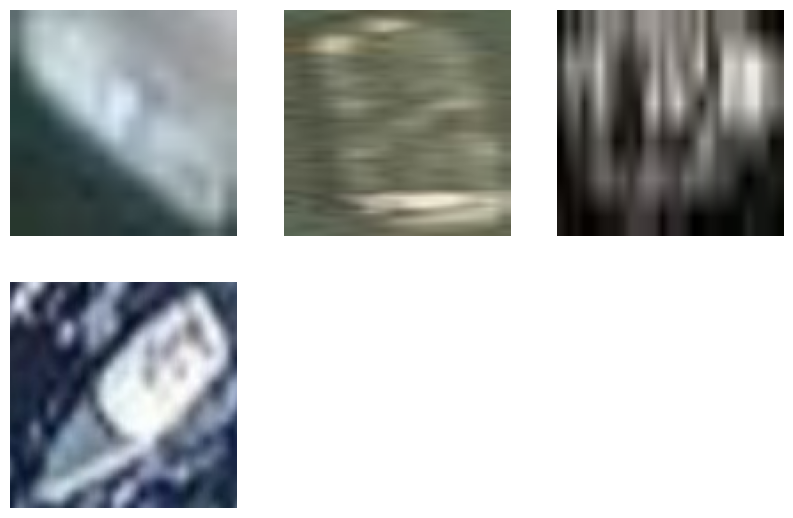

In [10]:
# Display some images from the dataset
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):  # Obtém o batch e ignora os rótulos (caso existam)
    for i in range(min(4, images.shape[0])):  # Exibe no máximo 9 imagens
        plt.subplot(3, 3, i + 1)  # Define a posição no grid (3x3)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))  # Exibe cada imagem
        plt.axis("off")
plt.show()

## Treinamento

In [11]:
hypermodel = AutoencoderTSNEHyperModel(
    input_shape=(Config.imgsz, Config.imgsz, 3),
    train_dataset=train_dataset.repeat(),
    use_kmeans=Config.use_kmeans,
    experiments_path=Config.experiments_path
)

In [12]:
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=Config.max_trials,
    directory=f'f{Config.experiments_path}/tsne_tuner_dir',
    project_name=f'tsne_optimization'
)

In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
encoding_dim (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 512], 'ordered': True}
tsne_n_components (Choice)
{'default': 2, 'conditions': [], 'values': [2], 'ordered': True}
tsne_perplexity (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 45, 'step': 5, 'sampling': 'linear'}
n_clusters (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 15, 'step': 1, 'sampling': 'linear'}


In [14]:
tuner.search()

Trial 2 Complete [00h 00m 00s]

Best val_loss So Far: None
Total elapsed time: 00h 00m 02s


## Resultados

In [15]:
def plot_autoencoder_results(encoder, decoder, dataset, n_images=10):
    """
    Plota resultados do autoencoder: imagens originais e reconstruídas lado a lado.
    """
    plt.figure(figsize=(20, 4))
    for i, (images, _) in enumerate(dataset.take(1)):
        if i >= n_images:
            break
        # Pega uma imagem do dataset
        original_image = images[i].numpy()
        # Reconstrói a imagem com o autoencoder
        latent_space = encoder.predict(original_image[np.newaxis, ...])
        reconstructed_image = decoder.predict(latent_space)[0]

        # Plotar a imagem original
        plt.subplot(2, n_images, i + 1)
        plt.imshow(original_image)
        plt.title("Original")
        plt.axis("off")

        # Plotar a imagem reconstruída
        plt.subplot(2, n_images, i + n_images + 1)
        plt.imshow(reconstructed_image)
        plt.title("Reconstruída")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [16]:
def browse_dataset(dataset, n_images=16):
    """
    Exibe imagens do dataset em uma grade.
    """
    plt.figure(figsize=(10, 10))
    for i, (images, _) in enumerate(dataset.take(1)):
        for j in range(min(n_images, len(images))):
            plt.subplot(int(n_images ** 0.5), int(n_images ** 0.5), j + 1)
            plt.imshow(images[j].numpy())
            plt.axis("off")
        break
    plt.tight_layout()
    plt.show()

In [17]:
def plot_cluster_examples(tsne_embeddings, cluster_labels, dataset, n_examples_per_cluster=5):
    """
    Mostra exemplos de imagens para cada cluster gerado pelo K-Means.
    """
    clusters = np.unique(cluster_labels)
    cluster_indices = {cluster: [] for cluster in clusters}
    
    # Mapeia as imagens dos embeddings para os clusters
    for i, label in enumerate(cluster_labels):
        if len(cluster_indices[label]) < n_examples_per_cluster:
            cluster_indices[label].append(i)

    # Carrega todas as imagens em um array para fácil acesso
    all_images = []
    for images, _ in dataset.unbatch().take(len(cluster_labels)):
        all_images.append(images.numpy())
    all_images = np.array(all_images)

    # Plota exemplos de cada cluster
    for cluster, indices in cluster_indices.items():
        plt.figure(figsize=(10, 5))
        for i, index in enumerate(indices):
            plt.subplot(1, n_examples_per_cluster, i + 1)
            plt.imshow(all_images[index])
            plt.title(f"Cluster {cluster}")
            plt.axis("off")
        plt.suptitle(f"Exemplos do Cluster {cluster}", fontsize=16)
        plt.tight_layout()
        plt.show()

In [18]:
# Obtendo os melhores hiperparâmetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construindo o melhor modelo com os melhores hiperparâmetros
best_model = hypermodel.build(best_hp)

I0000 00:00:1734488540.356428   73603 service.cc:148] XLA service 0x7f79b8006640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734488540.356693   73603 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-12-17 23:22:20.512853: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734488540.713341   73603 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1734488545.306266   73603 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2024-12-17 23:22:26.678837: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


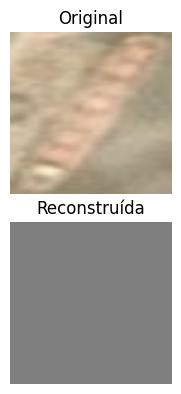

In [19]:
# Exibir imagens originais e reconstruídas
plot_autoencoder_results(best_model.encoder, best_model.decoder, train_dataset, n_images=10)

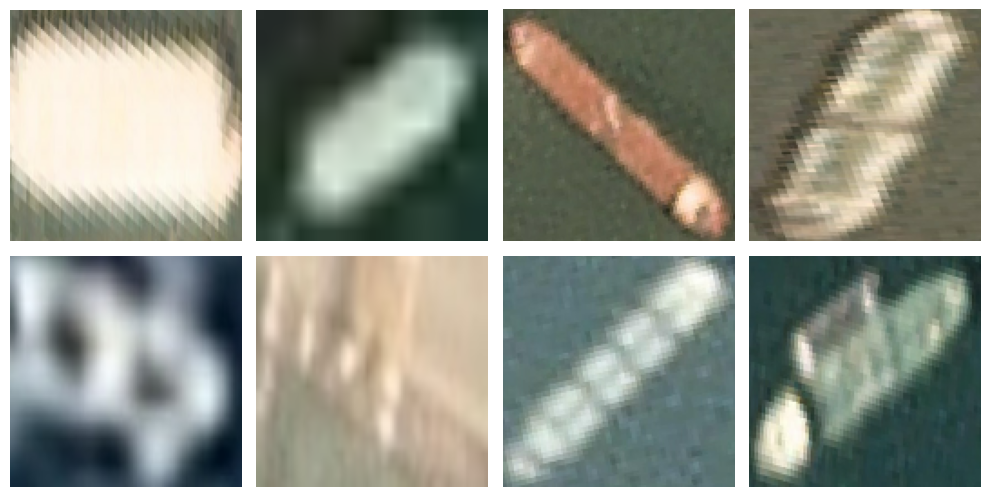

In [20]:

# Navegar pelo dataset
browse_dataset(train_dataset, n_images=16)

In [21]:
# Mostrar exemplos por cluster (se `use_kmeans=True`)
if Config.use_kmeans:
    # Substitua "trial_..." pelo diretório correto do melhor trial
    trial_path = os.path.join(Config.experiments_path, "tsne_tuner_dir", "trial_best")  # Ajuste o nome
    tsne_embeddings = np.load(os.path.join(trial_path, "tsne_embeddings.npy"))
    cluster_labels = np.load(os.path.join(trial_path, "cluster_labels.npy"))
    
    plot_cluster_examples(
        tsne_embeddings=tsne_embeddings,
        cluster_labels=cluster_labels,
        dataset=train_dataset,
        n_examples_per_cluster=5
    )

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/autoencoder/2024-12-17_23-22-01/tsne_tuner_dir/trial_best/tsne_embeddings.npy'